<a href="https://colab.research.google.com/github/walkerdustin/local_LLM_experiment/blob/main/seek.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook In Google Colab"/></a>  

In [1]:
import pandas as pd
import numpy as np
import subprocess
import pickle
import pythonbible as bible
import time
import os

In [2]:
verses = pd.read_csv("https://raw.githubusercontent.com/walkerdustin/local_LLM_experiment/main/t_web.csv")
# prompts should be a list of strings "{citation}: {text}"
verses

,id,b,c,v,t
0,1001001,1,1,1,"In the beginning God{After ""God,"" the Hebrew h..."
1,1001002,1,1,2,Now the earth was formless and empty. Darkness...
2,1001003,1,1,3,"God said, ""Let there be light,"" and there was ..."
3,1001004,1,1,4,"God saw the light, and saw that it was good. G..."
4,1001005,1,1,5,"God called the light Day, and the darkness he ..."
...,...,...,...,...,...
31097,66022017,66,22,17,"The Spirit and the bride say, ""Come!"" He who h..."
31098,66022018,66,22,18,I testify to everyone who hears the words of t...
31099,66022019,66,22,19,If anyone takes away from the words of the boo...
31100,66022020,66,22,20,"He who testifies these things says, ""Yes, I co..."


In [3]:
mathew_web_ids = bible.convert_reference_to_verse_ids(bible.NormalizedReference(book=bible.Book.MATTHEW, start_chapter=1, start_verse=1, end_chapter=28, end_verse=20, end_book=None),)

In [4]:
references = [bible.convert_verse_ids_to_references([id])[0] for id in list(mathew_web_ids)]
vers_references = [bible.format_single_reference(reference) for reference in references]

In [5]:
# get all the verses coresponding to the  ids
prompts = verses.loc[verses["id"].isin(mathew_web_ids), "t"].values
prompts

array(['The book of the generation of Jesus Christ{Christ (Greek) and Messiah (Hebrew) both mean "Anointed One"}, the son of David, the son of Abraham.',
       'Abraham became the father of Isaac. Isaac became the father of Jacob. Jacob became the father of Judah and his brothers.',
       'Judah became the father of Perez and Zerah by Tamar. Perez became the father of Hezron. Hezron became the father of Ram.',
       ...,
       'Jesus came to them and spoke to them, saying, "All authority has been given to me in heaven and on earth.',
       'Therefore go, and make disciples of all nations, baptizing them in the name of the Father and of the Son and of the Holy Spirit,',
       'teaching them to observe all things that I commanded you. Behold, I am with you always, even to the end of the age." Amen.'],
      dtype=object)

In [6]:
len(prompts)

1071

## calc how expensive this should be for different providers:

In [7]:
sys_prompt = """You are an expert in the use of the English language. You will get single paragraphs of the bible as an input and output in a single number (from 0 to 100)
how much this paragraph says about the concept of seeking discomfort. It is not relevant if the verse suggests that seeking discomfort is good or bad, it is about if the bible verse says anything about 
seeking discomfort in general. 
As guidance:
\'Book 1:30: And the Lord said you shall seek discomfort in all aspects of your life\' -> very high score
\'Book 1:30: And the Lord said you should make sure, that you never venture out of your comfort zone\' -> very high score
\'Book 1:30: Marc felt uncomfortable\' -> high score
\'Book 1:30: Marc built himself a cosy bed so that he can live comfortably\' -> high score
\'Book 1:30: Jesus made a difficult ride of 2 days to the next city\' -> medium score
\'Book 1:30: And so Jesus made water to wine\' -> low score
For the next prompt, you will output only one number. 0 represents the lowest correlation to the concept of comfort or 
discomfort and 100 represents the highest correlation to the concept of comfort and discomfort.
Only output a single number. Do not output any explanation or context."""
len(sys_prompt.split()) # number of tokens in system prompt

218

In [46]:
total_input_words = len("".join(prompts).split()) + len(sys_prompt.split())*len(prompts)
total_input_words

255829

In [9]:
total_output_tokens = len(prompts)*2
total_output_tokens

2142

## now calculate the tokens with openAIs tokenizer tiktoken

In [10]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"

# To get the tokeniser corresponding to a specific model in the OpenAI API:
enc = tiktoken.encoding_for_model("gpt-4")

In [11]:
# encoding with gpt-3 tokeniser
enc = tiktoken.encoding_for_model("gpt-4")
tiktoken_tokenizer_len = len(enc.encode("\n".join(prompts)))
tiktoken_tokenizer_len

29874

In [12]:
total_words = len("".join(prompts).split())
total_chars = len("".join(prompts))
print(f"openai tokenizer average words per token: {total_words/tiktoken_tokenizer_len}")
print(f"openai tokenizer average chars per token: {total_chars/tiktoken_tokenizer_len}")

openai tokenizer average words per token: 0.7481756711521724
openai tokenizer average chars per token: 4.135268126129745


In [13]:
len("\n".join(prompts))

124607

In [51]:
enc.encode("\n".join(prompts))

[791,
 2363,
 315,
 279,
 9659,
 315,
 10811,
 3771,
 90,
 19875,
 320,
 95448,
 8,
 323,
 81441,
 320,
 1548,
 22363,
 8,
 2225,
 3152,
 330,
 2127,
 85079,
 3861,
 14682,
 279,
 4538,
 315,
 6941,
 11,
 279,
 4538,
 315,
 37488,
 627,
 5953,
 17012,
 6244,
 279,
 7126,
 315,
 42608,
 13,
 42608,
 6244,
 279,
 7126,
 315,
 25537,
 13,
 25537,
 6244,
 279,
 7126,
 315,
 11462,
 1494,
 323,
 813,
 20820,
 627,
 62813,
 1494,
 6244,
 279,
 7126,
 315,
 50465,
 323,
 1901,
 97308,
 555,
 350,
 15924,
 13,
 50465,
 6244,
 279,
 7126,
 315,
 1283,
 89,
 2298,
 13,
 1283,
 89,
 2298,
 6244,
 279,
 7126,
 315,
 15504,
 627,
 64948,
 6244,
 279,
 7126,
 315,
 3383,
 1083,
 329,
 370,
 13,
 3383,
 1083,
 329,
 370,
 6244,
 279,
 7126,
 315,
 73088,
 939,
 263,
 13,
 73088,
 939,
 263,
 6244,
 279,
 7126,
 315,
 62826,
 627,
 17691,
 1677,
 6244,
 279,
 7126,
 315,
 2577,
 1394,
 555,
 33348,
 370,
 13,
 2577,
 1394,
 6244,
 279,
 7126,
 315,
 507,
 2788,
 555,
 42893,
 13,
 507,
 2788,
 6244,
 

In [15]:
tiktoken.list_encoding_names()

['gpt2', 'r50k_base', 'p50k_base', 'p50k_edit', 'cl100k_base']

In [16]:
# encoding with gpt-3 tokeniser
enc = tiktoken.get_encoding("cl100k_base")
total_input_tokens = len(enc.encode("\n".join(prompts))) + len(enc.encode(sys_prompt))*len(prompts)

In [54]:
# cost for openAi GPT-3.5
cost_for_gpt35 = total_input_tokens * 1/1_000_000 + total_output_tokens * 2/1_000_000
cost_for_gpt35

0.337251

In [53]:
# cost for openAi GPT-4
cost_for_gpt4 = total_input_tokens * 30/1_000_000 + total_output_tokens * 60/1_000_000
cost_for_gpt4

10.11753

In [52]:
# cost for google vertex-ai gemini pro
cost_for_gemini_pro = total_input_tokens * 0.25/1_000_000 + total_output_tokens * 0.5/1_000_000
cost_for_gemini_pro


0.08431275

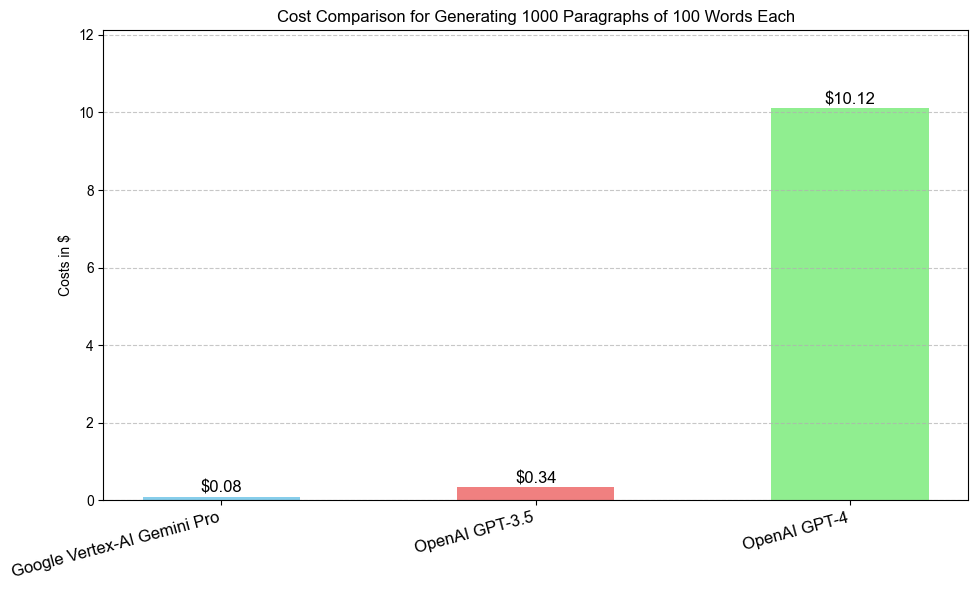

In [69]:
# make a colorfull barplot for the costs
import matplotlib.pyplot as plt

costs = [cost_for_gemini_pro, cost_for_gpt35, cost_for_gpt4]
labels = ["Google Vertex-AI Gemini Pro", "OpenAI GPT-3.5", "OpenAI GPT-4"]
colors = ['skyblue', 'lightcoral', 'lightgreen']

plt.figure(figsize=(10, 6))  # Adjust the figure size
plt.bar(labels, costs, color=colors, width=0.5)  # Adjust bar width and add colors
plt.ylabel("Costs in $")
plt.title("Cost Comparison for Generating 1000 Paragraphs of 100 Words Each")

# Add data labels above the bars
for i, cost in enumerate(costs):
    plt.text(i, cost+ 0.1, f"${cost:.2f}", ha='center', fontsize=12)

plt.ylim(0, max(costs) + 2)  # Adjust the y-axis limit for better visualization

# Rotate x-axis labels for better readability
plt.xticks(rotation=15, ha='right', fontsize=12)

# Add a grid for better reference
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot as "costs.png" with high DPI for better quality
plt.savefig("costs.png", dpi=300)
plt.tight_layout()
plt.show()

## get responses from different models

In [20]:
# construct a dataframe for all the verses and respones
3 experiment_df = pd.DataFrame({
    "vers_text": prompts,
    "bible_vers_id":mathew_web_ids,
     "vers_references":vers_references
    })
experiment_df

,vers_text,bible_vers_id,vers_references
0,The book of the generation of Jesus Christ{Chr...,40001001,Matthew 1:1
1,Abraham became the father of Isaac. Isaac beca...,40001002,Matthew 1:2
2,Judah became the father of Perez and Zerah by ...,40001003,Matthew 1:3
3,Ram became the father of Amminadab. Amminadab ...,40001004,Matthew 1:4
4,Salmon became the father of Boaz by Rahab. Boa...,40001005,Matthew 1:5
...,...,...,...
1066,"But the eleven disciples went into Galilee, to...",40028016,Matthew 28:16
1067,"When they saw him, they bowed down to him, but...",40028017,Matthew 28:17
1068,"Jesus came to them and spoke to them, saying, ...",40028018,Matthew 28:18
1069,"Therefore go, and make disciples of all nation...",40028019,Matthew 28:19


In [21]:
# read in the experiment df from the previous run
# read from csv
experiment_df = pd.read_csv("experiment_df.csv")

### get responses from palm 2 (text-bison)

In [22]:
import vertexai
from vertexai.language_models import TextGenerationModel
# this authentication works in online google colab notebook
# from google.colab import auth
# auth.authenticate_user()

# !gcloud auth login  ## authentication should work in jupyter notebook

# this authentication works in a local ipython notebook and local python
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/git_repos/try-out-vertex-ai-1d0862b91c6d.json' 

In [23]:
vertexai.init(project="try-out-vertex-ai", location="us-central1", service_account="364724547982-compute@developer.gserviceaccount.com")
parameters = {
    "candidate_count": 1,
    "max_output_tokens": 12,
    "temperature": 0,
    "top_k": 1
}
model = TextGenerationModel.from_pretrained("text-bison")
response = model.predict(
    """You are an expert in the use of the English language. You will get single paragraphs of the bible as an input and output in a single number (from 0 to 100)
how much this paragraph says about the concept of seeking discomfort. It is not relevant if the verse suggests that seeking discomfort is good or bad, it is about if the bible verse says anything about 
seeking discomfort in general. 
As guidance:
\'Book 1:30: And the Lord said you shall seek discomfort in all aspects of your life\' -> very high score
\'Book 1:30: And the Lord said you should make sure, that you never venture out of your comfort zone\' -> very high score
\'Book 1:30: Marc felt uncomfortable\' -> high score
\'Book 1:30: Marc built himself a cosy bed so that he can live comfortably\' -> high score
\'Book 1:30: Jesus made a difficult ride of 2 days to the next city\' -> medium score
\'Book 1:30: And so Jesus made water to wine\' -> low score
For the next prompt, you will output only one number. 0 represents the lowest correlation to the concept of comfort or 
discomfort and 100 represents the highest correlation to the concept of comfort and discomfort.
Only output a single number. Do not output any explanation or context.

input: Matthew 7:18,Matthew,7,18,\"A good tree cannot bring forth evil fruit, neither can a corrupt tree bring forth good fruit.\"



output:
""",
    **parameters
)
print(f"Response from Model: {response.text}")

Response from Model:  0


In [24]:
system_prompt = """You are an expert in the use of the English language. You will get single paragraphs of the bible as an input and output in a single number (from 0 to 100)
how much this paragraph says about the concept of seeking discomfort. It is not relevant if the verse suggests that seeking discomfort is good or bad, it is about if the bible verse says anything about 
seeking discomfort in general. 
As guidance:
\'Book 1:30: And the Lord said you shall seek discomfort in all aspects of your life\' -> very high score
\'Book 1:30: And the Lord said you should make sure, that you never venture out of your comfort zone\' -> very high score
\'Book 1:30: Marc felt uncomfortable\' -> high score
\'Book 1:30: Marc built himself a cosy bed so that he can live comfortably\' -> high score
\'Book 1:30: Jesus made a difficult ride of 2 days to the next city\' -> medium score
\'Book 1:30: And so Jesus made water to wine\' -> low score
For the next prompt, you will output only one number. 0 represents the lowest correlation to the concept of seeking comfort or 
discomfort and 100 represents the highest correlation to the concept of seeking comfort and discomfort.
Only output a single number. Do not output any explanation or context.

input: """

In [25]:
cols = list(experiment_df.columns)
cols

['Unnamed: 0',
 'vers_text',
 'bible_vers_id',
 'gpt_3_5_response_objects',
 'gpt_3_5_ratings',
 'gemini_pro_response_objects',
 'gemini_pro_ratings',
 'text_bison_response_objects',
 'text_bison_ratings',
 'vers_references']

In [26]:
# if the column text_bison_ratings already exists, then read skip this execution
if "text_bison_ratings" in cols:
    print("text_bison_ratings already exists")
else:
    # get the score for each prompt
    text_bison_responses = []
    text_bison_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in prompts:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
            print("waiting")
            while time.time() - last_start_timestamp < 61:
                pass
            last_start_timestamp = time.time()
        response = model.predict(system_prompt + prompt, **parameters)
        print(f"Response from Model: {response.text}")
        text_bison_responses.append(response.text)
        text_bison_response_objects.append(response)

    # strip all responses
    text_bison_responses_int = [int(response.strip()) if response.strip() != "" else -1 for response in text_bison_responses ]
    print(len(text_bison_responses_int))
    # add text_bison_responses_int as colmn to df
    experiment_df.insert(2,"text_bison_ratings", text_bison_responses_int)
    experiment_df.insert(2,"text_bison_response_objects", text_bison_response_objects)


text_bison_ratings already exists


### get responses from gemini pro

In [27]:
import vertexai
from vertexai.preview.generative_models import GenerativeModel, Part
model = GenerativeModel("gemini-pro")
generation_config={
  "candidate_count": 1,
  "max_output_tokens": 12,
  "temperature": 0,
  "top_k": 1
}
prompt = "Hello Gemini."
responses = model.generate_content(prompt, generation_config=generation_config)
responses.candidates[0].text

'Hello! As a large language model, I am designed to'

In [28]:
cols

['Unnamed: 0',
 'vers_text',
 'bible_vers_id',
 'gpt_3_5_response_objects',
 'gpt_3_5_ratings',
 'gemini_pro_response_objects',
 'gemini_pro_ratings',
 'text_bison_response_objects',
 'text_bison_ratings',
 'vers_references']

In [29]:
# if the column gemini_pro_ratings already exists, then read skip this execution
if "gemini_pro_ratings" in cols:
    print("gemini_pro_ratings already exists")
else:
    # get the score for each prompt
    gemini_pro_responses = []
    gemini_pro_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in prompts:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
            print("waiting")
            while time.time() - last_start_timestamp < 61:
                pass
            last_start_timestamp = time.time()
        response = responses = model.generate_content(system_prompt + prompt, generation_config=generation_config)
        try:
            text = response.candidates[0].text
        except ValueError:
            text = "-1"
        print(text)
        gemini_pro_responses.append(text)
        gemini_pro_response_objects.append(response)
    gemini_pro_responses_int = [int(response.strip()) if response.strip() != "" else -1 for response in gemini_pro_responses ]
    print(len(gemini_pro_responses_int))
    experiment_df.insert(2,"gemini_pro_ratings", gemini_pro_responses_int)
    experiment_df.insert(2,"gemini_pro_response_objects", gemini_pro_response_objects)



gemini_pro_ratings already exists


In [30]:
pd.set_option('display.max_colwidth', 0)

In [31]:
experiment_df.sort_values("gemini_pro_ratings", ascending=False)[["vers_text", "gemini_pro_ratings", "text_bison_ratings"]].head(20)

,vers_text,gemini_pro_ratings,text_bison_ratings
100,"""Blessed are you when people reproach you, persecute you, and say all kinds of evil against you falsely, for my sake.",80,80
551,"Then Jesus said to his disciples, ""If anyone desires to come after me, let him deny himself, and take up his cross, and follow me.",80,80
590,"If your hand or your foot causes you to stumble, cut it off, and cast it from you. It is better for you to enter into life maimed or crippled, rather than having two hands or two feet to be cast into the eternal fire.",70,50
65,Then Jesus was led up by the Spirit into the wilderness to be tempted by the devil.,70,80
310,"He who doesn't take his cross and follow after me, isn't worthy of me.",70,80
133,"But I tell you, love your enemies, bless those who curse you, do good to those who hate you, and pray for those who mistreat you and persecute you,",70,50
594,"""What do you think? If a man has one hundred sheep, and one of them goes astray, doesn't he leave the ninety-nine, go to the mountains, and seek that which has gone astray?",50,50
384,"For as Jonah was three days and three nights in the belly of the whale, so will the Son of Man be three days and three nights in the heart of the earth.",50,20
387,"But the unclean spirit, when he is gone out of the man, passes through waterless places, seeking rest, and doesn't find it.",50,50
220,"Jesus said to him, ""The foxes have holes, and the birds of the sky have nests, but the Son of Man has nowhere to lay his head.""",50,20


## use Openai Api

In [35]:
# set the openai Api key in the enviroment with
# setx OPENAI_API_KEY "your-api-key-here"

# or in python with
# os.environ["OPENAI_API_KEY"] = "your-api-key-here"

In [36]:
system_prompt = """You are an expert in the use of the English language. You will get single paragraphs of the bible as an input and output in a single number (from 0 to 100)
how much this paragraph says about the concept of seeking discomfort. It is not relevant if the verse suggests that seeking discomfort is good or bad, it is about if the bible verse says anything about 
seeking discomfort in general. 
As guidance:
\'Book 1:30: And the Lord said you shall seek discomfort in all aspects of your life\' -> very high score
\'Book 1:30: And the Lord said you should make sure, that you never venture out of your comfort zone\' -> very high score
\'Book 1:30: Marc felt uncomfortable\' -> high score
\'Book 1:30: Marc built himself a cosy bed so that he can live comfortably\' -> high score
\'Book 1:30: Jesus made a difficult ride of 2 days to the next city\' -> medium score
\'Book 1:30: And so Jesus made water to wine\' -> low score
For the next prompt, you will output only one number. 0 represents the lowest correlation to the concept of seeking comfort or 
discomfort and 100 represents the highest correlation to the concept of seeking comfort and discomfort.
Only output a single number. Do not output any explanation or context.
"""

In [37]:
from openai import OpenAI
client = OpenAI()
# defaults to getting the key using os.environ.get("OPENAI_API_KEY")
# if you saved the key under a different environment variable name, you can do something like:
# client = OpenAI(
#   api_key=os.environ.get("CUSTOM_ENV_NAME"),
# )
def get_GPT3_5_response(prompt):
  completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    max_tokens=12,
    temperature=0,
    messages=[
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": prompt}
    ]
  )
  return completion
print(get_GPT3_5_response(prompts[31]).choices[0].message)

ChatCompletionMessage(content='0', role='assistant', function_call=None, tool_calls=None)


In [38]:
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": prompts[30]}
  ]
)
print(completion.choices[0].message.content)
completion

40


ChatCompletion(id='chatcmpl-8dLB2RXW8IvPMGKwJo8huWrybdwWy', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='40', role='assistant', function_call=None, tool_calls=None))], created=1704386888, model='gpt-3.5-turbo-0613', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=1, prompt_tokens=335, total_tokens=336))

In [39]:
cols

['Unnamed: 0',
 'vers_text',
 'bible_vers_id',
 'gpt_3_5_response_objects',
 'gpt_3_5_ratings',
 'gemini_pro_response_objects',
 'gemini_pro_ratings',
 'text_bison_response_objects',
 'text_bison_ratings',
 'vers_references']

In [40]:
# if the column gpt_3_5_ratings already exists, then read skip this execution
if "gpt_3_5_ratings" in cols:
    print("gpt_3_5_ratings already exists")
else:
    # get the score for each prompt
    gpt_3_5_responses = []
    gpt_3_5_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in prompts:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
        response = get_GPT3_5_response(prompt)
        print(response.choices[0].message.content)
        gpt_3_5_responses.append(response.choices[0].message.content)
        gpt_3_5_response_objects.append(response)
    last_start_timestamp = time.time()
    print("all", len(prompts), "prompts took:", last_start_timestamp - start_timestamp, "seconds")
    gpt_3_5_responses_int = [int(response.strip()) if response.strip() != "" else -1 for response in gpt_3_5_responses ]

    len(gpt_3_5_responses_int)

    experiment_df.insert(2,"gpt_3_5_ratings", gpt_3_5_responses_int)
    experiment_df.insert(2,"gpt_3_5_response_objects", gpt_3_5_response_objects)

    experiment_df.sort_values("gpt_3_5_ratings", ascending=False)[["vers_text", "gpt_3_5_ratings", "text_bison_ratings"]].head(20)

gpt_3_5_ratings already exists


In [41]:
experiment_df.sort_values("gpt_3_5_ratings", ascending=False)[["vers_text", "gemini_pro_ratings", "text_bison_ratings", "gpt_3_5_ratings"]].head(20)

,vers_text,gemini_pro_ratings,text_bison_ratings,gpt_3_5_ratings
93,"Blessed are those who mourn, For they shall be comforted.",20,0,80
178,"""Ask, and it will be given you. Seek, and you will find. Knock, and it will be opened for you.",50,50,60
130,"Whoever compels you to go one mile, go with him two.",50,50,60
898,"for I was hungry, and you gave me food to eat; I was thirsty, and you gave me drink; I was a stranger, and you took me in;",20,0,50
100,"""Blessed are you when people reproach you, persecute you, and say all kinds of evil against you falsely, for my sake.",80,80,50
640,"Jesus said to his disciples, ""Most assuredly I say to you, a rich man will enter into the Kingdom of Heaven with difficulty.",20,20,50
179,For everyone who asks receives. He who seeks finds. To him who knocks it will be opened.,50,50,50
520,"Jesus summoned his disciples and said, ""I have compassion on the multitude, because they continue with me now three days and have nothing to eat. I don't want to send them away fasting, or they might faint on the way.""",20,0,20
60,"Then Jesus came from Galilee to the Jordan to John, to be baptized by him.",0,0,20
65,Then Jesus was led up by the Spirit into the wilderness to be tempted by the devil.,70,80,20


In [42]:
# safe the experiment_df with pickle
# experiment_df.to_pickle("experiment_df.pkl")

# safe the experiment_df as csv
experiment_df.to_csv("experiment_df.csv")

In [43]:
# read from csv
experiment_df_2 = pd.read_csv("experiment_df.csv")

## run it with openai and langchain

In [44]:
from langchain.llms import OpenAI
llm = OpenAI()

In [45]:
error! weil stop

SyntaxError: invalid syntax (715911468.py, line 1)

In [ ]:
# # run ollama run seeker2 "{prommpt}" for all prompts ans save the return value
# vers_ratings_dict = dict()
# i = 0
# N = len(prompts)
# for prompt in prompts:
#     i += 1
#     if i % 100 == 0:
#         print(f'Processing prompt {i} => {i/N:.2%}')
#         # save dict with pickle 
#         pickle.dump(vers_ratings_dict, open( "vers_ratings_dict.p", "wb" ))
#     try:
#         command = f'ollama run seeker2 "{prompt}"'
#         print(command)
#         out = subprocess.check_output(command, shell=True).decode('utf-8')
#         print(out)
#         vers_ratings_dict[prompt] = out
#     except:
#         print(f'Execption while processing prompt: "{prompt}"')
#         continue


In [ ]:
command = 'ollama run seeker2 "Matthew 7:13, Enter ye in at the strait gate: for wide is the gate, and broad is the way, that leadeth to destruction, and many there be which go in thereat:"'

In [ ]:
command = "ollama"
import subprocess

In [ ]:
ret = subprocess.run(command, shell=True, check=True, capture_output=True)
print(ret.stdout.decode())

In [ ]:
from langchain.llms import Ollama
ollama = Ollama(base_url='http://localhost:11434',
model="seeker2")

In [ ]:
ollama.predict("Genesis 1:1: In the beginning God created the heaven and the earth.")

In [ ]:
print(ollama("Matthew 7:13, Enter ye in at the strait gate: for wide is the gate, and broad is the way, that leadeth to destruction, and many there be which go in thereat:"))